# Semantic Scene Segmentation using Bag of Features

The goal of the project is to learn and implement a system for BoW (bag-of-World)-based semantic segmentation. So, you have to design your system carefully to make it perform in the best mode.

- Read the following papers (relevant parts).</br>
    [1] Szeliski’s Book Ch. 14.3.2, 14.1, and 14.4.1.</br>
    [2] [J. Winn, A. Criminisi and T. Minka. Object Categorization by Learned Universal Visual Dictionary.ICCV 2005.](http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=C4E210DA161167619DD8456F9EF0778E?doi=10.1.1.93.8714&rep=rep1&type=pdf)</br>
    [3] [Renninger, L.W. and Malik, J. When is scene recognition just texture recognition? Vision Research 2004.](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/walker-vr-04.pdf)</br>
    [4] VL Feat Code & reference: [VLFeat 0.9.20 binary package](http://www.vlfeat.org/download.html), and [VL Feat Matlab reference](http://www.vlfeat.org/matlab/matlab.html)</br>
    [5] [A. Rabinovich, A. Vedaldi, C. Galleguillos, E. Wiewiora, S. Belongie. Objects in Context. ICCV 2007.](http://cseweb.ucsd.edu/~sjb/iccv2007a.pdf)</br>
    [6] [J. Shotton, J. Winn, C. Rother, A. Criminisi. TextonBoost for Image Understanding: Multi-Class Object Recognition and Segmentation by Jointly Modeling Texture, Layout, and Context. IJCV 2007.](http://jamie.shotton.org/work/publications/ijcv07a.pdf)</br>
    [7] [S. Gould, J. Rodgers, D. Cohen, G. Elidan, D. Koller. Multi-class segmentation with relative location prior, IJCV 2008](http://pluto.huji.ac.il/~galelidan/papers/ElidanSegmentation.pdf)</br>
    [8] [K. Grauman and T. Darrell. The Pyramid Match Kernel: Discriminative Classification with Sets of Image Features. ICCV 2005.](https://www.cs.utexas.edu/~grauman/papers/grauman_darrell_iccv2005.pdf)
- Your goal is to implement a superpixel-based semantic scene segmentation algorithm [5,7] that uses BoW to represent and classify superpixels and evaluate the performance. 
- 13 image classes ([MSRC v1 dataset](https://www.microsoft.com/en-us/research/project/image-understanding/)) will be used for training and testing (120 training images and 120 test images for each category)


In [838]:
import numpy as np
import os
import cv2
import math
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries
from sklearn import svm
import pickle
import time
from skimage.exposure import rescale_intensity

## 0. Data preparation 
- [MSRC v1 dataset](https://www.microsoft.com/en-us/research/project/image-understanding/)
- 13 classes 
- 130 training images
- 110 test images
- image shape (213,320,3)

Num of train_img : 130
Num of train_gt : 130 
Num of test_img : 110 
Num of test_gt : 110


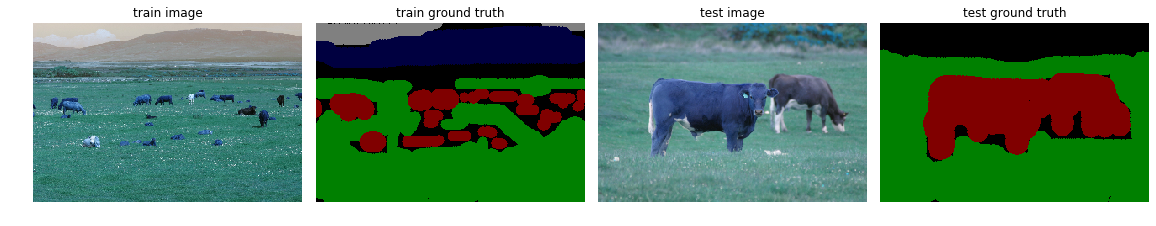

In [718]:
train_img = []
train_gt = []
test_img = []
test_gt = []
img_shape = (213,320,3)

for i,file_name in enumerate(sorted(os.listdir("./data/"))) :
    image = cv2.imread("./data/" + file_name)
    if "GT" in file_name :
        x,idx,_,_ = file_name.split("_")
    else : 
        _,idx,_ = file_name.split("_")
    if image.shape != (213,320,3) :
        image = np.transpose(image,(1,0,2))
    if int(idx) >= 0 and int(idx) < 16 : 
        if "GT" in file_name :
            train_gt.append(image)
        else : 
            train_img.append(image)
    else :    
        if int(x) == 1 and (int(idx) >=23 and int(idx)<=30) :
            if "GT" in file_name :
                train_gt.append(image)
            else :
                train_img.append(image)
            continue
        if int(x) == 5 and (int(idx) == 20 or int(idx) ==30) :
            if "GT" in file_name :
                train_gt.append(image)
            else :
                train_img.append(image)
            continue
        if "GT" in file_name :
            test_gt.append(image)
        else : 
            test_img.append(image)
train_img_rgb = np.asarray(train_img)
test_img_rgb = np.asarray(test_img)
train_gt_rgb = np.asarray(train_gt)
test_gt_rgb = np.asarray(test_gt)
print(f'Num of train_img : {len(train_img)}\nNum of train_gt : {len(train_gt)} \nNum of test_img : {len(test_img)} \nNum of test_gt : {len(test_gt)}')
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1, 4, 1)
plt.axis("off")
plt.imshow(train_img[0])
plt.title("train image")
fig.add_subplot(1, 4, 2)
plt.axis("off")
plt.imshow(train_gt[0])
plt.title("train ground truth")
fig.add_subplot(1, 4, 3)
plt.axis("off")
plt.imshow(test_img[0])
plt.title("test image")
fig.add_subplot(1, 4, 4)
plt.axis("off")
plt.imshow(test_gt[0])
plt.title("test ground truth")

plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()    

## 1. Constructing dictionary using Texton features.
### 1-1. Filter banks for texton features
- Create filter bank as in [2] using following filters; 3 Gaussians with different sigmas (σ=1,2,4), 4 LoG (Laplacian of Gaussians) (with σ=1,2,4,8) and 4 DoG (Derivative of Gaussians) (vertically and horizontaly aligned with σ=2,4 for each). You may choose the scale, orientation and support of each filter for the best performance. 
- Visualize the filters you have designed.

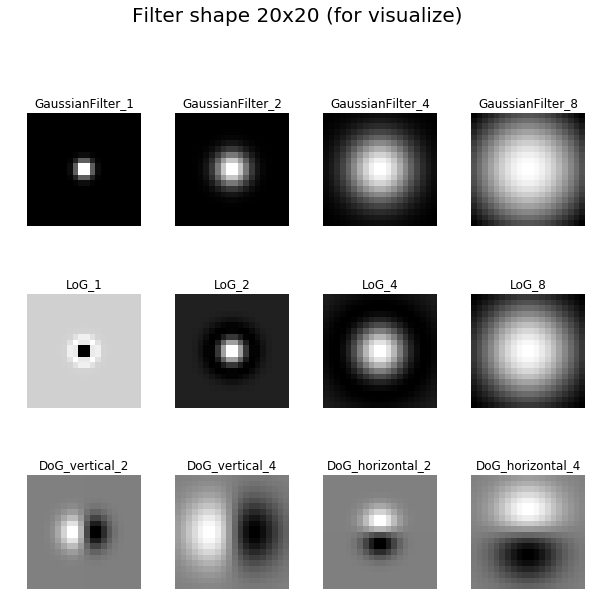

In [308]:
# Filter banks for texton features
def gaussian_filter(filter_shape,sigma) :
    G = np.empty(filter_shape)
    m,n = [(s-1.)/2. for s in filter_shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    G = np.exp( -(x*x + y*y) / (2.*sigma*sigma) ) / 2*math.pi*sigma*sigma
    G /= np.sum(G)
    return G

def LoG_filter(filter_shape,sigma) : 
    LoG = np.empty(filter_shape)
    m,n = [(s-1.)/2. for s in filter_shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    LoG = np.exp(-(x*x+y*y) / (2.*sigma*sigma) ) / math.pi*(sigma**4) * (1-(x*x+y*y)/(2.*sigma*sigma))
    LoG /= np.sum(LoG)
    return LoG

def DoG_filter(filter_shape,direction,sigma) :
    DoG = np.empty(filter_shape)
    m,n = [(s-1.)/2. for s in filter_shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    if direction == "Vertical":
        DoG = -y * np.exp(-(x*x+y*y) / (2.*sigma*sigma) ) / (2.*math.pi*(sigma**4))
    elif direction == "Horizontal" :
        DoG = -x * np.exp(-(x*x+y*y) / (2.*sigma*sigma) ) / (2.*math.pi*(sigma**4))
    else : 
        DoG = None
    return DoG

def get_filter_bank(fs,visualize=False) :
    filter_shape = fs
    filter_bank= {}
    filter_bank['GaussianFilter_1'] = gaussian_filter(filter_shape,sigma=1)
    filter_bank['GaussianFilter_2'] = gaussian_filter(filter_shape,sigma=2)
    filter_bank['GaussianFilter_4'] = gaussian_filter(filter_shape,sigma=4)
    if visualize == True :
        filter_bank['GaussianFilter_8'] = gaussian_filter(filter_shape,sigma=8)
    filter_bank['LoG_1'] = LoG_filter(filter_shape,sigma=1)
    filter_bank['LoG_2'] = LoG_filter(filter_shape,sigma=2)
    filter_bank['LoG_4'] = LoG_filter(filter_shape,sigma=4)
    filter_bank['LoG_8'] = LoG_filter(filter_shape,sigma=8)
    filter_bank['DoG_vertical_2'] = DoG_filter(filter_shape,direction="Vertical",sigma=2)
    filter_bank['DoG_vertical_4'] = DoG_filter(filter_shape,direction="Vertical",sigma=4)
    filter_bank['DoG_horizontal_2'] = DoG_filter(filter_shape,direction="Horizontal",sigma=2)
    filter_bank['DoG_horizontal_4'] = DoG_filter(filter_shape,direction="Horizontal",sigma=4)
    return filter_bank

filter_shape_v = (20,20)
filter_bank_v = get_filter_bank(filter_shape_v,visualize=True)
fig = plt.figure(figsize=(10,10))
plt.suptitle("Filter shape {}x{} (for visualize)".format(filter_shape_v[0],filter_shape_v[1]),fontsize="20")
i=1
for key,filters in filter_bank_v.items() :
    fig.add_subplot(3, 4, i)
    plt.axis("off") 
    plt.imshow(filters,cmap="gray")
    plt.title(key)
    i+=1
    
plt.subplots_adjust(hspace=0, wspace=0.3)
plt.show()    

### 1.2 Texton features
- To obtain texton features for each pixel, apply the filter bank to the training input images using the CIE Lab color space. The three Gaussian filters are applied to each CIE Lab channel, while the LoG and DoG filters are applied to the L channel only.

In [719]:
# Texton features
def convolution_with_filters(train_imgs,filter_):
    texton_feature = np.empty(0)
    
    for key,value in filter_.items() :  
        tfs = []
        for i in range(len(train_imgs)) :
            if "Gaussian" in key :
                tf = cv2.filter2D(train_imgs[i],-1,value)
            else :
                tf = cv2.filter2D(train_imgs[i][:,:,0],-1,value)
            tfs.append(tf)
        tfs = np.asarray(tfs)
        if len(tfs.shape) == 3 :
            tfs = tfs.reshape(tfs.shape[0],tfs.shape[1],tfs.shape[2],1)
        if texton_feature.size == 0 :
            texton_feature = tfs
        else :
            texton_feature = np.append(texton_feature,tfs,axis=3)
    return texton_feature

filter_bank = get_filter_bank((5,5))
train_imgs = []
train_gt_imgs = []
test_imgs = []
test_gt_imgs = []
for i,img in enumerate(train_img) :
    train_imgs.append(cv2.cvtColor(train_img[i], cv2.COLOR_RGB2LAB))
    train_gt_imgs.append(cv2.cvtColor(train_gt[i], cv2.COLOR_RGB2LAB))
for i,img in enumerate(test_img) :
    test_imgs.append(cv2.cvtColor(test_img[i], cv2.COLOR_RGB2LAB))
    test_gt_imgs.append(cv2.cvtColor(test_gt[i], cv2.COLOR_RGB2LAB))
train_imgs = np.asarray(train_imgs)
texton_feature_train = convolution_with_filters(train_imgs,filter_bank)
texton_feature_train_gt = convolution_with_filters(train_gt_imgs,filter_bank)
texton_feature_test = convolution_with_filters(test_imgs,filter_bank)
texton_feature_test_gt = convolution_with_filters(test_gt_imgs,filter_bank)

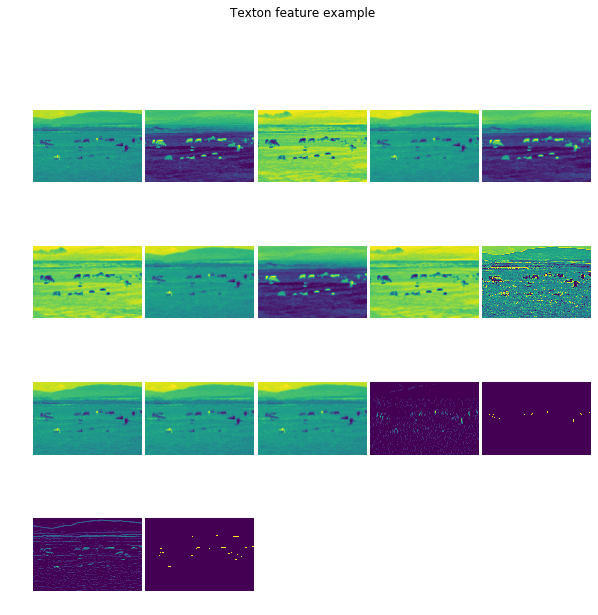

In [754]:
tt2 = np.transpose(texton_feature_train,(0,3,1,2))

fig = plt.figure(figsize=(10,10))
plt.suptitle("Texton feature example")
for i in range(1,18) :
    fig.add_subplot(4, 5, i)
    plt.axis("off") 
    plt.imshow(tt2[0][i-1])
plt.subplots_adjust(hspace=0.01, wspace=0.03)
plt.show()    

### 1.3 Constructing Dictionary
- Use simple K-means [5] (or vocabulary tree [3]) for the training features to learn the dictionary centers (visual words).
- Set the appropriate dictionary size. You may need bigger dictionary size K (K = 100 or more)
- Generate the visual vocabulary 


In [396]:
visual_vocab = {}
kmeans_model_filename = "kmeans_model.pkl"
model_dir = "./models/"
filename = model_dir + kmeans_model_filename
kmeans_feature = np.reshape(texton_feature_train,(-1,texton_feature_train.shape[3]))
if os.path.exists(filename) :
    print(f'Loading kmeans model in ({filename})...')
    kmeans_model = pickle.load(open(filename, 'rb'))
else :
    start_time = time.time()
    if not os.path.exists('models'):
        os.makedirs('models')
    print(f'Generating kmeans model...')
    kmeans_model = MiniBatchKMeans(n_clusters=100,random_state=0,batch_size=100)
    print(f'Fitting the kmeans model...')
    kmeans_model = kmeans_model.fit(kmeans_feature)
    pickle.dump(kmeans_model, open(filename, 'wb')) 
    print(f'Saving kmeans model in ({filename})...')
    end_time = time.time() - start_time
    print(f'Kmeans clustering takes {end_time:.3} secs')
print("Generating visual vocabulary...")
visual_vocab = kmeans_model.cluster_centers_
print("Done")

Generating kmeans model...
Fitting the kmeans model...
Saving kmeans model in (./models/kmeans_model.pkl)...
Kmeans clustering takes 1.09e+02 secs
Generating visual vocabulary...
Done


## 2. Superpixel representation
- Each image in the training and test datasets can be decomposed into superpixels.
- You can use the code from superpixel or the VLFeat function SLIC


In [315]:
def segment_colorfulness(image, mask):
    (B, G, R) = cv2.split(image.astype("float"))
    R = np.ma.masked_array(R, mask=mask)
    G = np.ma.masked_array(G, mask=mask)
    B = np.ma.masked_array(B, mask=mask)
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)
    stdRoot = np.sqrt((rg.std() ** 2) + (yb.std() ** 2))
    meanRoot = np.sqrt((rg.mean() ** 2) + (yb.mean() ** 2))
    
    return stdRoot + (0.3 * meanRoot)

def get_superpixel_img(image) :
    superpixel_img = []
    segments = []
    for img in image :
#         predict = kmeans_model.predict(img.reshape(-1,1))
#         kmeans_img = visual_vocab[predict]
#         kmeans_img = np.reshape(kmeans_img,img.shape)
#         kmeans_img = cv2.normalize(kmeans_img,None,0,1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
        segment = slic(img,n_segments=750,slic_zero=True)
        vis = np.zeros(segment.shape[:2], dtype="float")
        for v in np.unique(segment) :
            mask = np.ones(segment.shape[:2])
            mask[segment == v] = 0
            C = segment_colorfulness(img, mask)
            vis[segment == v] = C
        superpixel_img.append(vis)
        segments.append(segment)
    return np.asarray(superpixel_img),np.asarray(segments)
    
superpixel_train_img,train_segments = get_superpixel_img(train_img_rgb)
superpixel_test_img,test_segments = get_superpixel_img(test_img_rgb)

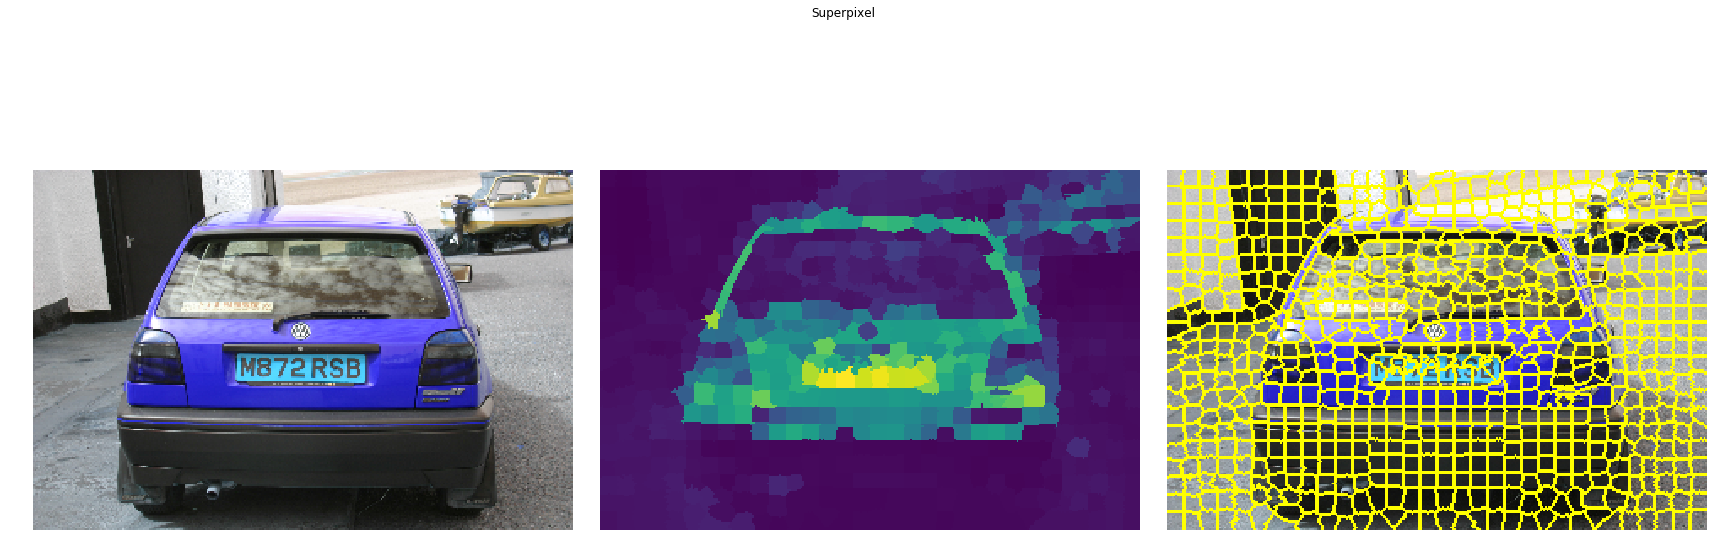

In [758]:
fig = plt.figure(figsize=(30,10))
plt.suptitle("Superpixel")
fig.add_subplot(1,3,1)
plt.imshow(train_img[100])
plt.axis("off")
fig.add_subplot(1,3,2)
plt.imshow(superpixel_train_img[100])
plt.axis("off")
fig.add_subplot(1,3,3)
plt.imshow(mark_boundaries(train_img[100], train_segments[100]))
plt.axis("off")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()

## 3.BoW representation
- Each feature in a training and test image is quantized to the nearest visual word.
- And each superpixel is represented by the histogram of visual words. Note that the histogram should be normalized to sum to one.
- MATLAB functions: hist

In [503]:
def sp_idx(s, index = True):
    u = np.unique(s)
    return [np.where(s == i) for i in u]

def get_superpixel_list(image,segments_slic) :
    superpixel_list = sp_idx(segments_slic)
    superpixel      = [image[idx] for idx in superpixel_list]
    return superpixel

histogramss = []
for i in range(len(texton_feature_train)) :
    superpixels = get_superpixel_list(texton_feature_train[i],train_segments[i])
    histograms = []
    for superpixel in superpixels :
        visual_words = kmeans_model.predict(superpixel)
        histogram,_ = np.histogram(visual_words,bins=np.arange(101), density=True)
        histograms.append(histogram)
    histogramss.append(np .asarray(histograms))
histogramss = np.asarray(histogramss)

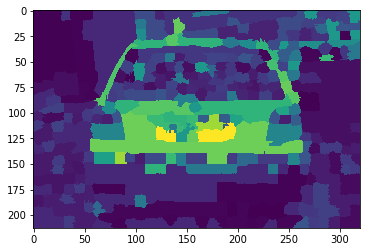

In [655]:
segment = np.ones(train_segments[100].shape)
segment = np.reshape(segment,(-1))
for v in np.unique(train_segments[100]) :
    idx = np.where(v==train_segments[100].reshape(-1))
    segment[idx] = np.argmax(histogramss[100][v])

vis = np.zeros(segment.shape[:2], dtype="float")
for v in np.unique(segment) :
    mask = np.ones(segment.shape[:2])
    mask[segment == v] = 0
    C = segment_colorfulness(train_img[100], mask)
    vis[segment == v] = C

plt.imshow(vis.reshape(213,320))

## 4. MRF fomulation
- To assign an object class to each superpixel, the Markov random field energy functional is defined by $E(l)=\sum_{p} f\left(l_{p}\right)+\sum_{(p, q) \in N} \theta_{p q}\left(l_{p}, l_{q}\right)$ (1) where $l_p$ is the object class label of superpixel $p,N$ is the set of the neighboring superpixels. The unary potential $f(l_p)$ is the chi-square distance [3] between the superpixel $p$ and the object class $l_p$ in the BoW space, while the pairwise potentials (Potts model) are set as $\theta_{p q}\left(l_{p}, l_{q}\right)=\left\{\begin{array}{l}{0 \text { if } l_{p}=l_{q}} \\ {\lambda \text { if } l_{p} \neq l_{q}}\end{array}\right.$ where $\lambda$ is constant parameter

In [790]:
labels = []
for i in range(len(texton_feature_train_gt)) :
    superpixels = get_superpixel_list(texton_feature_train_gt[i],train_segments[i])
    label = []
    for superpixel in superpixels :
        visual_words = kmeans_model.predict(superpixel)
        histogram,_ = np.histogram(visual_words,bins=np.arange(101), density=True)
        label.append(histogram)
    labels.append(np.asarray(label))
labels = np.asarray(labels)
labels_copy = np.copy(labels)
labels = np.concatenate(labels,axis=0)
X_copy = np.copy(histogramss)
X = np.concatenate(histogramss,axis=0)

In [822]:
# http://peekaboo-vision.blogspot.com/2011/08/region-connectivity-graphs-in-python.html
def make_graph(grid):
    # get unique labels
    vertices = np.unique(grid)
 
    # map unique labels to [1,...,num_labels]
    reverse_dict = dict(zip(vertices,np.arange(len(vertices))))
    grid = np.array([reverse_dict[x] for x in grid.flat]).reshape(grid.shape)
   
    # create edges
    down = np.c_[grid[:-1, :].ravel(), grid[1:, :].ravel()]
    right = np.c_[grid[:, :-1].ravel(), grid[:, 1:].ravel()]
    all_edges = np.vstack([right, down])
    all_edges = all_edges[all_edges[:, 0] != all_edges[:, 1], :]
    all_edges = np.sort(all_edges,axis=1)
    num_vertices = len(vertices)
    edge_hash = all_edges[:,0] + num_vertices * all_edges[:, 1]
    # find unique connections
    edges = np.unique(edge_hash)
    # undo hashing
    edges = [[vertices[x%num_vertices],vertices[x//num_vertices]] for x in edges] 
 
    return vertices, edges

def unary_potential(X,label):
    return 0.5*np.sum((X-label)**2/(X+label+1e-6))

def pairwise_potential(label,segment) : 
    vertices,edges = make_graph(segment)
    pair_wise = 0
    for edge in edges :
        if not np.array_equal(labels_copy[i][edge[0]],labels_copy[i][edge[1]]) :
            pair_wise += constant 
    return pair_wise,edges


## 5. Inference
- Use [Graph cut(Multi-label optimization)](https://vision.cs.uwaterloo.ca/code/)[($\alpha$-expansion)](https://vision.cs.uwaterloo.ca/code/gco-v3.0.zip) to optimize the energy function (1)

ValueError: Buffer has wrong number of dimensions (expected 2, got 0)

## 6. Display some result of your Algorithm

## 7. Test
- Run your algorithm on the test images, construct the confusion matrix [5] and report the per-pixel and per-class classification accuracy [7]

In [ ]:
"""
VOID = 0;BUILDING=1;GRASS=2;TREE=3;COW=4;HORSE=5;SHEEP=6;SKY=7;MOUNTAIN=8;AEROPLANE=9;WATER=10;FACE=11;CAR=12;BICYCLE=13
obj_class = {VOID : np.array([0,0,0]) 
            ,BUILDING : np.array([0,0,128])  
            ,GRASS : np.array([0,128,0])
            ,TREE : np.array([0,128,128])
            ,COW : np.array([128,0,0])
            ,HORSE : np.array([128,0,128])
            ,SHEEP : np.array([128,128,0])
            ,SKY : np.array([128,128,128])
            ,MOUNTAIN : np.array([0,0,64])
            ,AEROPLANE : np.array([0,0,192])
            ,WATER : np.array([0,128,64])
            ,FACE : np.array([0,128,192])
            ,CAR : np.array([128,0,64])
            ,BICYCLE : np.array([128,0,192])}
num_class = len(obj_class)
superpixels_gt = []
for i in range(len(train_gt)) :
    superpixel_gt = []
    superpixels = get_superpixel_list(train_gt[i],train_segments[i])
    for superpixel in superpixels :
        idx,cnt = np.unique(superpixel,axis=0,return_counts=True)
        obj = idx[np.argmax(cnt)]
        label = [key for key,value in obj_class.items() if np.array_equal(obj,value)][0]
        #label = np.eye(num_class)[label]
        superpixel_gt.append(label)
    superpixels_gt.append(np.asarray(superpixel_gt))
superpixels_gt = np.asarray(superpixels_gt)
"""